In [1]:
import os
import subprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lidar

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
lidar_records = lidar.get_lidar_records()
bicycle_records = lidar.get_bicycle_records()
records = list(zip(lidar_records, bicycle_records))

In [3]:
# If we try to plot all the data, jupyter will crash
def reduced_signal(time, signal, tol=1e-6):
    """Return time and signal arrays with the runs
    reduced to 2 subsequent elements.
    > reduced_signal([0, 1, 2, 3, 4], [0, 0, 0, 1, 2])
    > [0, 2, 3, 4], [0, 0, 1, 2]
    """
    time = np.asarray(time)
    signal = np.asarray(signal)
    event = np.where(np.abs(np.diff(signal)) > tol)[0] + 1
    
    index = [0] # include first element
    
    for i in event:
        skip = i - index[-1]
        
        # If we skip more than one index include 
        # previous index so that edges are preserved
        assert skip > 0
        if skip > 1:
            index.append(i - 1)
        index.append(i)
        
    # add last element if the signal ends in a run
    if index[-1] != len(time) - 1:
        index.append(len(time) - 1)
    
    return time[index], signal[index]


a = np.array([0, 0, 0, 1, 1, 2, 3, 0, 0])
t = np.arange(len(a)) + 1
print(t)
print(a)

print(*reduced_signal(t, a))

[1 2 3 4 5 6 7 8 9]
[0 0 0 1 1 2 3 0 0]
[1 3 4 5 6 7 8 9] [0 0 1 1 2 3 0 0]


In [4]:
lidar, bicycle = records[0]
print('length of lidar signal: {}'.format(len(lidar.time)))
print('length of bicycle signal: {}'.format(len(bicycle.time)))

# convert time to the nearest millisecond
lidar_dt = np.round(np.diff(lidar.time)*1000)/1000
bicycle_dt = np.round(np.diff(bicycle.time)*1000)/1000

reduced_lidar_dt = reduced_signal(lidar.time[1:], lidar_dt)
reduced_bicycle_dt = reduced_signal(bicycle.time[1:], bicycle_dt)
print('length of reduced lidar signal: {} ({:0.2f}%)'.format(
   len(reduced_lidar_dt[0]), len(reduced_lidar_dt[0])/len(lidar.time)*100
))
print('length of reduced bicycle signal: {} ({:0.2f}%)'.format(
   len(reduced_bicycle_dt[0]), len(reduced_bicycle_dt[0])/len(bicycle.time)*100
))

length of lidar signal: 28356
length of bicycle signal: 172099
length of reduced lidar signal: 1036 (3.65%)
length of reduced bicycle signal: 3875 (2.25%)


In [5]:
def plot_record_timeseries(record):
    lidar, bicycle = record
    # convert time to the nearest millisecon
    sig_dt = lambda x: np.round(np.diff(x.time)*1000)/1000
    lidar_dt = sig_dt(lidar)
    bicycle_dt = sig_dt(bicycle)
    
    colors = sns.color_palette('Paired', 10)
    
    def plot_two(axis, x1, y1, x2, y2, color_index, label):
        l1 = axis.plot(x1, y1,
                       color=colors[color_index],
                       label='lidar {}'.format(label))
        l2 = axis.plot(x2, y2,
                       color=colors[color_index + 1],
                       label='bicycle {}'.format(label))
    
    
    fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    plot_two(
        ax[0],
        *reduced_signal(lidar.time[1:], lidar_dt),
        *reduced_signal(bicycle.time[1:], bicycle_dt),
        0, 'sample time'
    )
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('sample time [s]')
    ax[0].legend()
    
    plot_two(
        ax[1],
        *reduced_signal(lidar.time, lidar.sync),
        *reduced_signal(bicycle.time, bicycle.sync),
        2, 'sync'
    )
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('button status')
    ax[1].legend()
    
    plt.show()
    return fig, ax

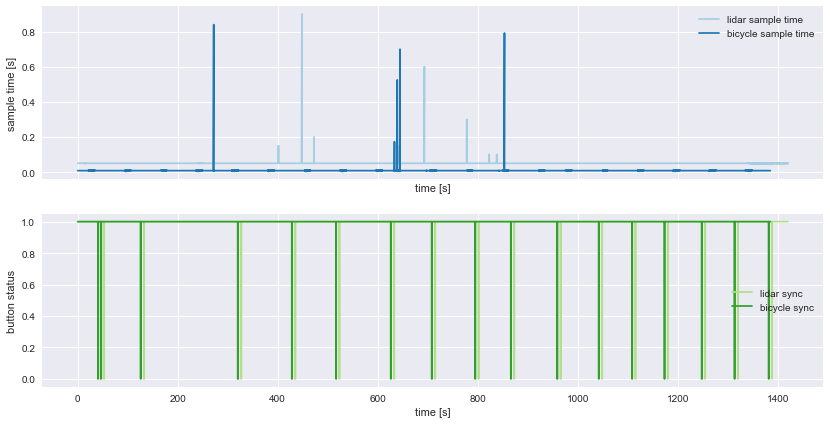

(<matplotlib.figure.Figure at 0x1110a2358>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b688160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120770080>], dtype=object))

In [6]:
plot_record_timeseries(records[0])

In [7]:
"""TODO
 - maximize autocorrelation of sync signal
 - determine bounds on time sync error
 - determine bounds on distance error (bicycle to obstacle) corresponding to time sync error
"""

'TODO\n - maximize autocorrelation of sync signal\n - determine bounds on time sync error\n - determine bounds on distance error (bicycle to obstacle) corresponding to time sync error\n'